In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython import display
from tqdm.auto import tqdm, trange

#Load dataset

the MNIST dataset contains 70000 images of hand written digits. usually 60000 of these images are used for training and the remaining 10000 are used for testing/validation. The size of the images are 28$\times$28, and they are grayscale.

In [3]:
batch_size=64
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform = transforms.Compose([transforms.ToTensor()]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform = transforms.Compose([transforms.ToTensor()]))
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

trainset.__len__(), testset.__len__()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



(60000, 10000)

label: 2


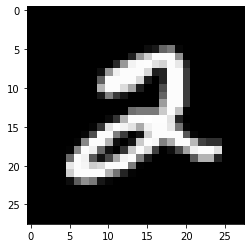

In [4]:
#visualize a single image

sample_image, sample_label = trainset.__getitem__(5)

sample_image = sample_image.squeeze(0).numpy()

print('label:', sample_label)
plt.imshow(sample_image, cmap='gray')
plt.show()



#Define model without residual connections

1. Define basic block, consisting of a simpl 3$\times$3 convolution layer which does not change input size and channel number + ReLU
2. Define the first module consisting of 100 basic blocks without residual connections

In [53]:
class BasicBlock(nn.Module):
  def __init__(self, num_channels):
    super(BasicBlock, self).__init__()

    self.conv = nn.Conv2d(in_channels=num_channels, out_channels = num_channels, kernel_size=3, padding = 1)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.conv(x)
    x = self.activation(x)

    return x

class ResBlock(nn.Module):
  def __init__(self, num_channels):
    super(ResBlock, self).__init__()

    self.conv = nn.Conv2d(in_channels=num_channels, out_channels = num_channels, kernel_size=3, padding = 1)
    self.activation = nn.ReLU()

  def forward(self, x):
    o = self.conv(x)
    o = self.activation(o)

    return o + x

class Net100(nn.Module):
  def __init__(self, num_channels, resnet = False):
    super(Net100, self).__init__()

    #1x1 convolution to adjust number of channels
    self.adjusting_conv = nn.Conv2d(in_channels = 1, out_channels=num_channels, kernel_size = 1)
    self.relu = nn.ReLU()

    self.basic_blocks = nn.ModuleList()

    self.linear1 = nn.Linear(in_features = 28 * 28 * num_channels, out_features=128)
    self.linear2 = nn.Linear(in_features = 128, out_features = 64)

    self.final_layer = nn.Linear(in_features = 64, out_features = 10)


    for i in range(20):
      if resnet:
        self.basic_blocks.append(ResBlock(num_channels))
      else:
        self.basic_blocks.append(BasicBlock(num_channels))


  def forward(self, x):
    x = self.adjusting_conv(x)
    for i in range(20):
      x = self.basic_blocks[i](x)

    x = nn.Flatten()(x)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.final_layer(x)

    return x




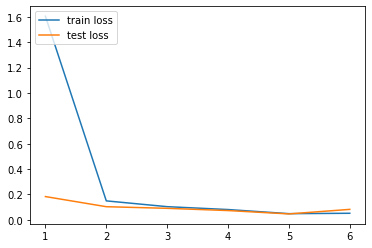

w gradient: 0.0953168203104724
b gradient: 1.2985098729623132


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [55]:

num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net100(16, resnet=False).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

train_log = []
test_log = []

for e in range(1, num_epochs + 1):
  model.train()
  train_loss = 0

  param_grads = [0, 0]
  for i, data in enumerate(tqdm(trainloader,desc='Batches', leave=False)):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    preds = model(images)

    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()


    for j, p in enumerate(model.adjusting_conv.parameters()):
      param_grads[j] += p.grad.mean().item()

    optimizer.zero_grad()

    train_loss += loss.item()
  train_log.append(train_loss / i)
  scheduler.step()

  model.eval()
  test_loss = 0
  with torch.no_grad():
    for i, data in enumerate(testloader):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      preds = model(images)

      loss = criterion(preds, labels)
      test_loss += loss.item()
    
    test_log.append(test_loss / i)

  plt.plot(range(1, e+1), train_log, color='C0', label = 'train loss')
  plt.plot(range(1, e+1), test_log, color='C1', label = 'test loss')
  plt.legend(loc="upper left")
  display.clear_output(wait=True)
  display.display(plt.gcf())
  plt.clf()
  print('w gradient:', param_grads[0])
  print('b gradient:', param_grads[1])


  



    